# Convolution in Graph Neural Networks

### forward pass in graph convolutional neural network
<img src="https://miro.medium.com/max/480/1*2cT063K_PIvJVRqFn8c5gg.png"></img>

#### Building Graph Convolutional Networks
**Initializing the Graph G**
Let’s start by building a simple undirected graph (G) using NetworkX. The graph G will consist of 6 nodes and the feature of each node will correspond to that particular node number. For example, node 1 will have a node feature of 1, node 2 will have a node feature of 2, and so on. To simplify, we are not going to assign edge features in this experiment.

Graph Info:
 Name: G
Type: Graph
Number of nodes: 6
Number of edges: 7
Average degree:   2.3333

Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


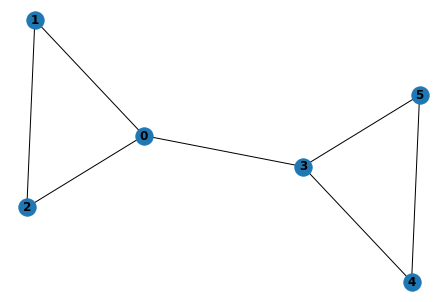

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#Initialize the graph
G = nx.Graph(name='G')

#Create nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(6):
    G.add_node(i, name=i)


#Define the edges and the edges to the graph
edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

#See graph info
print('Graph Info:\n', nx.info(G))

#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

**Inserting Adjacency Matrix (A) to Forward Pass Equation**
The next step is to obtain the Adjacency Matrix (A) and Node Features Matrix (X) from graph G.

In [2]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


Now, let’s investigate how by inserting A into the forward pass equation adds to richer feature representation of the model. We are going to perform dot product of A and X. Let’s call the result of this dot product operation as AX in this article.

In [3]:
#Dot product Adjacency Matrix (A) and Node Features (X)
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


From the results, it is apparent that AX represents the sum of neighboring nodes features. For example, the first row of AX corresponds to the sum of nodes features connected to node 0, which is node 1, 2, and 3. This gives us an idea how the propagation mechanism is happening in GCNs and how the node connectivity impacts the hidden features representation seen by GCNs.

But, if we think about it more, we will realize that while AX sums up the adjacent node features, it does not take into account the features of the node itself.

<hr>

**Inserting Self-Loops and Normalizing A**
To address this problem, we now add self-loops to each node of A. Adding self-loops is basically a mechanism to connect a node to itself. That being said, all the diagonal elements of Adjacency Matrix A will now become 1 because each node is connected to itself. Let’s call A with self-loops added as A_hat and recalculate AX, which is now the dot product of A_hat and X:

In [4]:
#Add Self Loops
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges)

#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

#Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


Now, you might recognize another problem. The elements of AX are not normalized. Similar to data pre-processing for any Neural Networks operation, we need to normalize the features to prevent numerical instabilities and vanishing/exploding gradients in order for the model to converge. In GCNs, we normalize our data by calculating the Degree Matrix (D) and performing dot product operation of the inverse of D with AX

In [5]:
#Get the Degree Matrix of the added self-loops graph
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

#Convert the Degree Matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

#Find the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

#Dot product of D and AX for normalization
DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


We can see the impact normalization has on DAX, where the element that corresponds to node 3 has lower values compared to node 4 and 5. But why would node 3 have different values after normalization if it has the same initial value as node 4 and 5?
Let’s take a look back at our graph. Node 3 has 3 incident edges, while nodes 4 and 5 only have 2 incident edges. The fact that node 3 has a higher degree than node 4 and 5 leads to a lower weighting of node 3’s features in DAX. In other words, the lower the degree of a node, the stronger that a node belongs to a certain group or cluster.


doing symmetric normalization will make dynamics more interesting, hence, the normalization equation is modified from
<img src="https://miro.medium.com/max/424/1*yd8uL8Ewj_C4ES5faZVUxg.png"></img>

In [6]:
#Symmetrically-normalization
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


**Adding Weights and Activation Function**
We are going to build a 2-layer GCN using ReLu as the activation function. To initialize the weights, we will use random seeds so we can replicate the results. Just keep in mind that the weight initialization cannot be 0. In this experiment, we are going to set 4 neurons for the hidden layer. As we will be plotting the feature representations in 2 dimensions, there will be 2 output neurons.

In [7]:
#Initialize the weights
np.random.seed(77777)
n_h = 4 #number of neurons in the hidden layer
n_y = 2 #number of neurons in the output layer
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_y) * 0.01

#Implement ReLu as activation function
def relu(x):
    return np.maximum(0,x)

#Build GCN layer
#In this function, we implement numpy to simplify
def gcn(A,H,W):
    I = np.identity(A.shape[0]) #create Identity Matrix of A
    A_hat = A + I #add self-loop to A
    D = np.diag(np.sum(A_hat, axis=0)) #create Degree Matrix of A
    D_half_norm = fractional_matrix_power(D, -0.5) #calculate D to the power of -0.5
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)


#Do forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00027758 0.        ]
 [0.00017298 0.        ]
 [0.00017298 0.        ]
 [0.00053017 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]]


**Plotting the Features Representations**
The ‘magic’ of GCN is that it can learn features representation even without training. Let’s visualize the features representations after passing through 2-layer GCN.

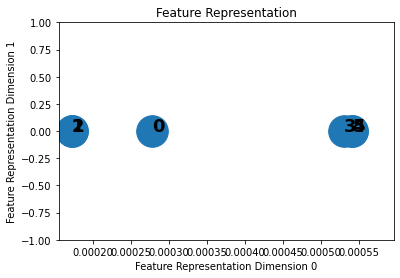

In [8]:
def plot_features(H2):
    #Plot the features representation
    x = H2[:,0]
    y = H2[:,1]

    size = 1000

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)

From the plot above, it can be clearly seen that there are 2 major groups, where the left group consists of nodes 0, 1, 2, and the right group consists of nodes 3, 4, 5. We can infer that the GCNs can already learn the feature representations even without training or backpropagation.